# RNN Track classifier

In this notebook we explore a model which classifies a sequence of hits as a real or spurious track candidate. The model will produce a prediction for every element of the sequence, allowing us to classify partial candidates and guide a combinatorial track building algorithm.

In [1]:
from __future__ import print_function
import os

# Data libraries
import numpy as np
import pandas as pd

# Deep learning
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt

# Local imports
from data import process_files
from track_filter import (select_hits, select_signal_hits,
                          remove_duplicate_hits, coord_scale)
from estimator import Estimator
import torchutils
torchutils.set_cuda(False)

%matplotlib notebook

In [2]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

def calc_dphi(phi1, phi2):
    """TODO: update this for signed dph"""
    dphi = np.abs(phi1 - phi2)
    idx = dphi > np.pi
    dphi[idx] = 2*np.pi - dphi[idx]
    return dphi

def calc_dR(eta1, eta2, phi1, phi2):
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(deta*deta + dphi*dphi)

def calc_phi_z_distance(phi1, phi2, z1, z2):
    dphi = calc_dphi(phi1, phi2)
    dz = np.abs(z1 - z2)
    return np.sqrt(dphi*dphi + dz*dz)

def calc_eta_phi_distance(r1, phi1, z1, r2, phi2, z2):
    # First, calculate the eta coordinates
    eta1 = calc_eta(r1, z1)
    eta2 = calc_eta(r2, z2)
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(dphi*dphi + deta*deta)    

## Load the data

In [3]:
data_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'

In [4]:
n_files = 10

all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(data_dir, f) for f in hits_files[:n_files]]

In [5]:
%%time

n_workers = 3
hits = process_files(hits_files, num_workers=n_workers)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_14.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_15.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_16.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_17.csv
CPU times: user 236 ms, sys: 296 ms, total: 532 ms
Wall time: 4min


In [6]:
print('Hits data shape:', hits.shape)

Hits data shape: (5252569, 7)


## Prepare the training samples

One difficult aspect of this problem is the selection of a good, representative training sample.
Ultimately we want track candidates representative of what might occur in the real application of such a model.

We're going to do something a little bit crude initially. I will randomly sample from the hits
around the true hit using a 1/(R+$\epsilon$) weighting. I can tune $\epsilon$ to achieve a
"balanced" training set.

Some other possible approaches under consideration:
- Sampled hits from one of the prediction models (e.g., gaussian)
- Full combinatorial tree from some limited set of hits around a track

In [7]:
%%time

# Select hits
selected_hits = remove_duplicate_hits(select_hits(hits))
print('selected barrel hits:', selected_hits.shape)
signal_hits = select_signal_hits(selected_hits)
print('signal track hits:', signal_hits.shape)

selected barrel hits: (2680308, 7)
signal track hits: (1359870, 7)
CPU times: user 3min 35s, sys: 1.41 s, total: 3min 37s
Wall time: 3min 37s


In [8]:
event_groups = selected_hits.groupby('evtid')
sample_keys = signal_hits[['evtid', 'barcode']].drop_duplicates().values

In [9]:
n_samples = sample_keys.shape[0]
print('Available sample keys:', n_samples)

Available sample keys: 135987


In [10]:
# Config
#n_samples = 1024
n_det_layers = 10
seed_size = 3
epsilon = 0.05
feature_names = ['r', 'phi', 'z']
n_features = len(feature_names)

In [11]:
# Sample hit features
indices = np.zeros((n_samples, n_det_layers), dtype=np.int)
features = np.zeros((n_samples, n_det_layers, n_features))
labels = np.zeros((n_samples, n_det_layers))

In [12]:
%%time

# Loop over samples
for i, k in enumerate(sample_keys[:n_samples]):

    # Gather the hits for this sample
    sample_hits = event_groups.get_group(k[0]).sort_values('layer')
    sample_labels = sample_hits.barcode == k[1]
    # Prepare the seed
    seed_hits = sample_hits[(sample_hits.layer < seed_size) &
                            (sample_hits.barcode == k[1])]
    features[i, :seed_size] = seed_hits[feature_names].values
    indices[i, :seed_size] = seed_hits.index
    labels[i, :seed_size] = 1
    real_track = True

    # Loop over layers
    for layer in range(seed_size, n_det_layers):

        # Select all candidate hits on the layer
        layer_hits = sample_hits[sample_hits.layer == layer]
        layer_labels = sample_labels.loc[layer_hits.index]

        # Extract the true hit
        true_hit = layer_hits[layer_labels].iloc[0]

        # Calculate distances of hits from the true hit
        dr = calc_eta_phi_distance(layer_hits.r, layer_hits.phi, layer_hits.z,
                                   true_hit.r, true_hit.phi, true_hit.z)

        # Calculate proximity weights regularized by epsilon
        w = 1 / (dr + epsilon)

        # Sample one hit from the candidates using proximity weights.
        # TODO: data standardizing
        sampled_hit = layer_hits.sample(weights=w)
        sampled_idx = sampled_hit.index[0]
        indices[i, layer] = sampled_idx
        features[i, layer] = sampled_hit[feature_names]
        real_track = real_track and layer_labels.loc[sampled_idx]
        labels[i, layer] = real_track

CPU times: user 1h 44min 6s, sys: 12.3 s, total: 1h 44min 18s
Wall time: 1h 44min 18s


In [13]:
print('True hit fraction:', labels.mean())
print('Features:', features.shape)
print('Indices:', indices.shape)
print('Labels:', labels.shape)

True hit fraction: 0.407319081971
Features: (135987, 10, 3)
Indices: (135987, 10)
Labels: (135987, 10)


## Define the model

We will use an RNN model to classify the sequences.

In [14]:
class HitSequenceClassifier(nn.Module):
    """
    A recurrent network model which classifies all elements of a hit sequence.
    """
    
    def __init__(self, n_features=3, hidden_dim=16):
        """Initialize the model"""
        super(HitSequenceClassifier, self).__init__()
        self.lstm = nn.LSTM(n_features, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Initialize the lstm hidden state
        var_args = [x.size(0), self.lstm.hidden_size]
        h0 = torchutils.torch_zeros(*var_args), torchutils.torch_zeros(*var_args)
        h, _ = self.lstm(x, h0)
        h = self.linear(h).squeeze(-1)
        return F.sigmoid(h)

## Train the model

In [15]:
# Setup logging
import logging
reload(logging)
log_format = '%(asctime)s %(levelname)s %(message)s'
logging.basicConfig(level=logging.INFO, format=log_format)

In [16]:
# Model config
hidden_dim = 32

# Training config
n_epochs = 16
batch_size = 32
valid_frac = 0

In [17]:
# Finalize the training data
train_x = torchutils.np_to_torch(features.astype(np.float32))
train_y = torchutils.np_to_torch(labels.astype(np.float32))

In [18]:
train_x[0]

Variable containing:
   32.2261     2.9506   -47.8166
   71.9911     2.9572   -79.2231
  115.6802     2.9647  -113.7280
  172.5484     2.9743  -158.6570
  262.5642     2.9896  -230.0000
  360.4879     3.0062  -309.0000
  502.2489     3.0303  -424.0000
  659.3094     3.0571  -539.0000
  821.3995     3.0848  -721.0000
 1021.2362     3.1192  -824.0000
[torch.FloatTensor of size 10x3]

In [19]:
# Construct the model, loss, and estimator
model = HitSequenceClassifier(hidden_dim=hidden_dim)
loss_func = nn.BCELoss()
estimator = Estimator(model, loss_func)

2018-02-09 18:19:42,484 INFO Model: 
HitSequenceClassifier(
  (lstm): LSTM(3, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1)
)
2018-02-09 18:19:42,485 INFO Parameters: 4769


In [20]:
estimator.fit(train_x, train_y, n_epochs=n_epochs)

2018-02-09 18:19:42,511 INFO Training samples: 135987
2018-02-09 18:19:42,511 INFO Batches per epoch: 4250
2018-02-09 18:19:42,512 INFO Epoch 0
2018-02-09 18:20:03,740 INFO   training loss 0.172 time 21.2274s
2018-02-09 18:20:03,742 INFO Epoch 1
2018-02-09 18:20:24,222 INFO   training loss 0.098 time 20.48s
2018-02-09 18:20:24,225 INFO Epoch 2
2018-02-09 18:20:45,225 INFO   training loss 0.0822 time 20.9996s
2018-02-09 18:20:45,228 INFO Epoch 3
2018-02-09 18:21:05,135 INFO   training loss 0.0753 time 19.9061s
2018-02-09 18:21:05,136 INFO Epoch 4
2018-02-09 18:21:24,875 INFO   training loss 0.0708 time 19.7376s
2018-02-09 18:21:24,876 INFO Epoch 5
2018-02-09 18:21:44,382 INFO   training loss 0.0682 time 19.5056s
2018-02-09 18:21:44,384 INFO Epoch 6
2018-02-09 18:22:04,247 INFO   training loss 0.0663 time 19.8629s
2018-02-09 18:22:04,248 INFO Epoch 7
2018-02-09 18:22:24,183 INFO   training loss 0.0647 time 19.9335s
2018-02-09 18:22:24,185 INFO Epoch 8
2018-02-09 18:22:46,305 INFO   train

<IPython.core.display.Javascript object>


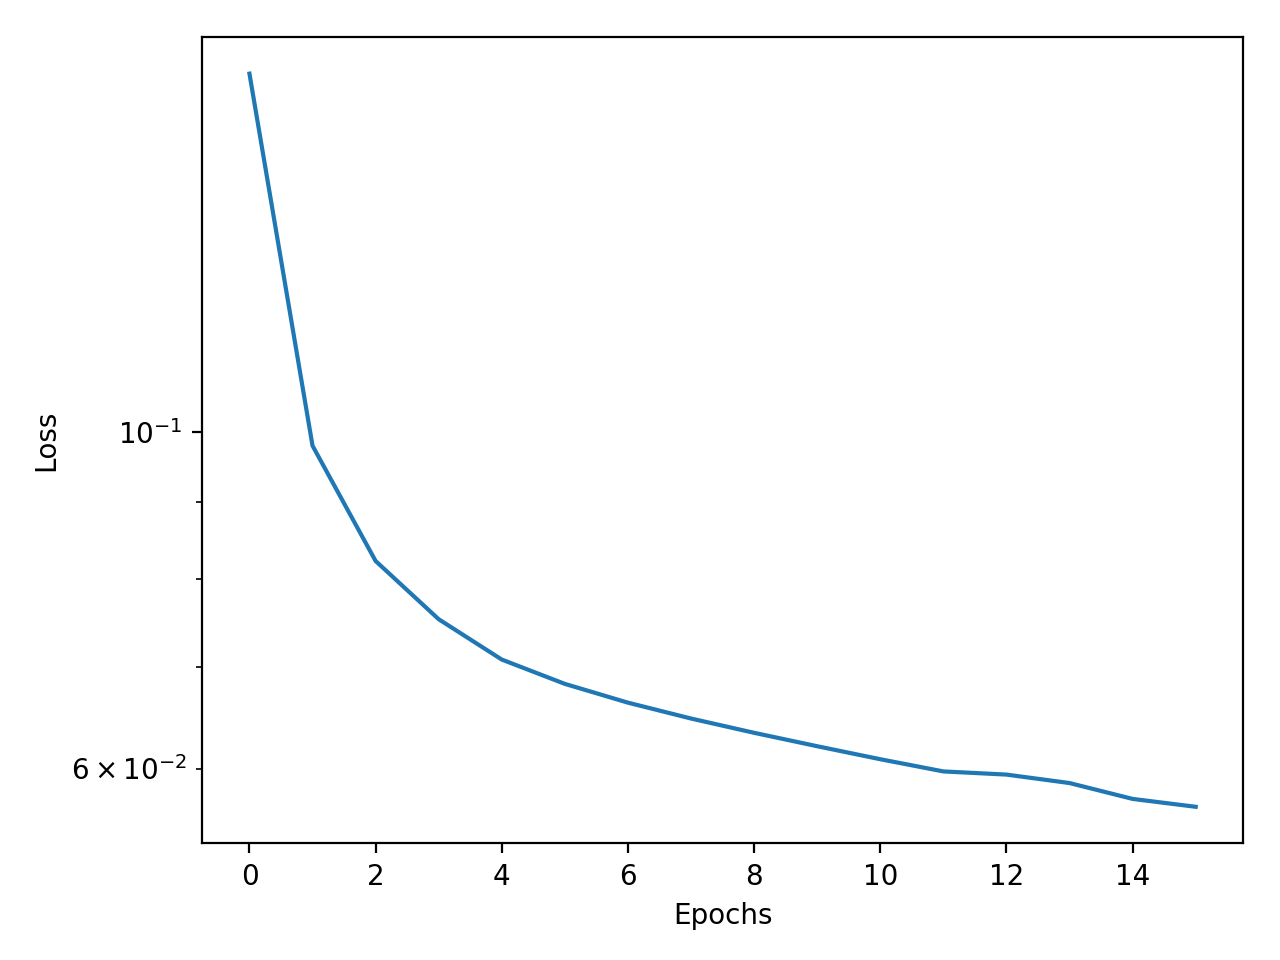

In [25]:
# Plot the training loss
plt.figure()
plt.semilogy(estimator.train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()

In [21]:
# Evaluate on the training set
train_pred = estimator.model(train_x)

In [22]:
threshold = 0.5
train_matches = (train_pred > threshold) == (train_y > threshold)

In [23]:
torchutils.torch_to_np(train_matches).mean()

0.97642862920720364

### ROC curve